In [5]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
#import seaborn as sns
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

from sklearn.metrics import classification_report, confusion_matrix


import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

In [6]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

In [7]:
# load dataset and clean it 
# split the train and test dataset based on subject ID to avoid data leakeage
# then normalize the data
subjects=pd.read_csv("subjects.csv")
subjects=subjects[subjects['Label (0 for the null class)']!=0]
subjects.reset_index(inplace=True)
subjects.drop(columns=['level_0','Unnamed: 0','index'],inplace=True)

sample = subjects.copy()

df_train=sample[(sample['subject_number']!=10)].drop(columns=['subject_number','electrocardiogram signal (lead 1)','electrocardiogram signal (lead 2)'])
df_test=sample[(sample['subject_number']==10)].drop(columns=['subject_number','electrocardiogram signal (lead 1)','electrocardiogram signal (lead 2)'])

pd.options.mode.chained_assignment = None  # default='warn'

for i in range(0,21):
    df_train[df_train.columns[i]] = df_train[df_train.columns[i]] / df_train[df_train.columns[i]].max()
    
for i in range(0,21):
    df_test[df_test.columns[i]] = df_test[df_test.columns[i]] / df_test[df_test.columns[i]].max()

In [8]:
# reshape the 1D data into a 3D one
# based on time_period (100) and number of features (21 here as it has 21 sensors)
# create overlap within data. Reason:There is some risk that the splitting of the stream of sensor data into windows
# may result in windows that miss the transition of one activity to another. 
TIME_PERIODS = 100
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 2

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 21
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs1 = df['acceleration from the chest sensor (X axis)'].values[i: i + time_steps]
        ys1 = df['acceleration from the chest sensor (Y axis)'].values[i: i + time_steps]
        zs1 = df['acceleration from the chest sensor (Z axis)'].values[i: i + time_steps]
        xs2 = df['acceleration from the left-ankle sensor (X axis)'].values[i: i + time_steps]
        ys2 = df['acceleration from the left-ankle sensor (Y axis)'].values[i: i + time_steps]
        zs2 = df['acceleration from the left-ankle sensor (Z axis)'].values[i: i + time_steps]
        xs3 = df['gyro from the left-ankle sensor (X axis)'].values[i: i + time_steps]
        ys3 = df['gyro from the left-ankle sensor (Y axis)'].values[i: i + time_steps]
        zs3 = df['gyro from the left-ankle sensor (Z axis)'].values[i: i + time_steps]
        xs4 = df['magnetometer from the left-ankle sensor (X axis)'].values[i: i + time_steps]
        ys4 = df['magnetometer from the left-ankle sensor (Y axis)'].values[i: i + time_steps]
        zs4 = df['magnetometer from the left-ankle sensor (Z axis)'].values[i: i + time_steps]
        xs5 = df['acceleration from the right-lower-arm sensor (X axis)'].values[i: i + time_steps]
        ys5 = df['acceleration from the right-lower-arm sensor (Y axis)'].values[i: i + time_steps]
        zs5 = df['acceleration from the right-lower-arm sensor (Z axis)'].values[i: i + time_steps]        
        xs6 = df['gyro from the right-lower-arm sensor (X axis)'].values[i: i + time_steps]
        ys6 = df['gyro from the right-lower-arm sensor (Y axis)'].values[i: i + time_steps]
        zs6 = df['gyro from the right-lower-arm sensor (Z axis)'].values[i: i + time_steps]        
        xs7 = df['magnetometer from the right-lower-arm sensor (X axis)'].values[i: i + time_steps]
        ys7 = df['magnetometer from the right-lower-arm sensor (Y axis)'].values[i: i + time_steps]
        zs7 = df['magnetometer from the right-lower-arm sensor (Z axis)'].values[i: i + time_steps]            
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs1, ys1, zs1, xs2, ys2, zs2, xs3, ys3, zs3, xs4, ys4, zs4, xs5, ys5, zs5, xs6, ys6, zs6, xs7, ys7, zs7])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              "Label (0 for the null class)")

In [9]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = 12

# re-asign the datatype
# perform one hot encoding of y train
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

y_train_hot = np_utils.to_categorical(y_train, 13)
print('New y_train shape: ', y_train_hot.shape)
y_train_hot = y_train_hot[:,1:]
print('New y_train shape: ', y_train_hot.shape)

x_train shape:  (154703, 100, 21)
154703 training samples
y_train shape:  (154703,)
New y_train shape:  (154703, 13)
New y_train shape:  (154703, 12)


In [10]:
# re-asign the datatype
# perform one hot encoding of y test
x_test, y_test = create_segments_and_labels(df_test,
                                              100,
                                              2,
                                              "Label (0 for the null class)")
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
input_shape = (100*21)
# x_test = x_test.reshape(x_test.shape[0], input_shape)

y_test_hot = np_utils.to_categorical(y_test, 13)
print('New y_test shape: ', y_test_hot.shape)
y_test_hot = y_test_hot[:,1:]
print('New y_test shape: ', y_test_hot.shape)

New y_test shape:  (16795, 13)
New y_test shape:  (16795, 12)


In [8]:
import theano

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" 

# create the multi-headed cnn model
verbose, epochs, batch_size = 1, 5, 100
n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train_hot.shape[1]
# head 1
inputs1 = Input(shape=(n_timesteps,n_features))
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)
# head 2
inputs2 = Input(shape=(n_timesteps,n_features))
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)
# head 3
inputs3 = Input(shape=(n_timesteps,n_features))
conv3 = Conv1D(filters=128, kernel_size=7, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)
# head 4
inputs4 = Input(shape=(n_timesteps,n_features))
conv4 = Conv1D(filters=128, kernel_size=11, activation='relu')(inputs4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling1D(pool_size=2)(drop4)
flat4 = Flatten()(pool4)
# merge
merged = concatenate([flat1, flat2, flat3, flat4])
# interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(n_outputs, activation='softmax')(dense1)


In [9]:
# compile and fit the model

model = Model(inputs=[inputs1, inputs2, inputs3, inputs4], outputs=outputs)
# save a plot of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit([x_train,x_train,x_train,x_train], y_train_hot, epochs=epochs, batch_size=batch_size, 
          validation_split=0.2,verbose=verbose)

Train on 123762 samples, validate on 30941 samples
Epoch 1/5
123762/123762 [==============================] - 1203s 10ms/step - loss: 0.0581 - accuracy: 0.9833 - val_loss: 0.6427 - val_accuracy: 0.8726
Epoch 2/5
123762/123762 [==============================] - 1311s 11ms/step - loss: 0.0191 - accuracy: 0.9953 - val_loss: 0.7024 - val_accuracy: 0.8964
Epoch 3/5
123762/123762 [==============================] - 1263s 10ms/step - loss: 0.0140 - accuracy: 0.9963 - val_loss: 1.4538 - val_accuracy: 0.7813
Epoch 4/5
123762/123762 [==============================] - 1249s 10ms/step - loss: 0.0143 - accuracy: 0.9969 - val_loss: 1.4191 - val_accuracy: 0.7991
Epoch 5/5
123762/123762 [==============================] - 1251s 10ms/step - loss: 0.0108 - accuracy: 0.9976 - val_loss: 1.3467 - val_accuracy: 0.8865


In [11]:
# evaluate model
_, accuracy = model.evaluate([x_test,x_test,x_test,x_test], y_test_hot, batch_size=batch_size, verbose=verbose)
print(accuracy)

16795/16795 [==============================] - 71s 4ms/step
0.9635605812072754


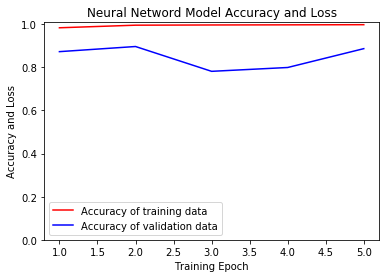

NameError: name 'confusion_matrix' is not defined

In [14]:
# get the evaluation plot for both train and validation dataset
plt.figure(figsize=(6, 4))
training_scores=[0.9833,0.9953,0.9963,0.9969,0.9976]
validation_scores=[0.8726,0.8964,0.7813,0.7991,0.8865]
plt.plot(range(1,6),training_scores, 'r', label='Accuracy of training data')
plt.plot(range(1,6),validation_scores, 'b', label='Accuracy of validation data')
plt.title('Neural Netword Model Accuracy')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict([x_train,x_train,x_train,x_train])
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)+1
class_report = classification_report(y_train, max_y_pred_train)
conf_mat = confusion_matrix(y_train, max_y_pred_train)
print(class_report)
print(conf_mat)

In [16]:
# get the confusion matrix and classification report
class_report = classification_report(y_train, max_y_pred_train)
conf_mat = confusion_matrix(y_train, max_y_pred_train)
print(class_report)
print(conf_mat)

              precision    recall  f1-score   support

         1.0       0.97      1.00      0.98     13805
         2.0       0.99      1.00      1.00     13824
         3.0       1.00      1.00      1.00     13824
         4.0       1.00      1.00      1.00     13824
         5.0       0.88      0.98      0.93     13799
         6.0       1.00      0.99      0.99     12929
         7.0       1.00      0.99      1.00     13336
         8.0       0.91      0.90      0.91     13236
         9.0       1.00      0.89      0.94     13824
        10.0       1.00      0.97      0.98     13824
        11.0       0.97      1.00      0.98     13824
        12.0       0.99      1.00      0.99      4654

    accuracy                           0.97    154703
   macro avg       0.98      0.98      0.98    154703
weighted avg       0.98      0.97      0.97    154703

[[13776     6     0     0     4     0     0     0     0     0     0    19]
 [    0 13792     2     6     0     0     6     0     0   

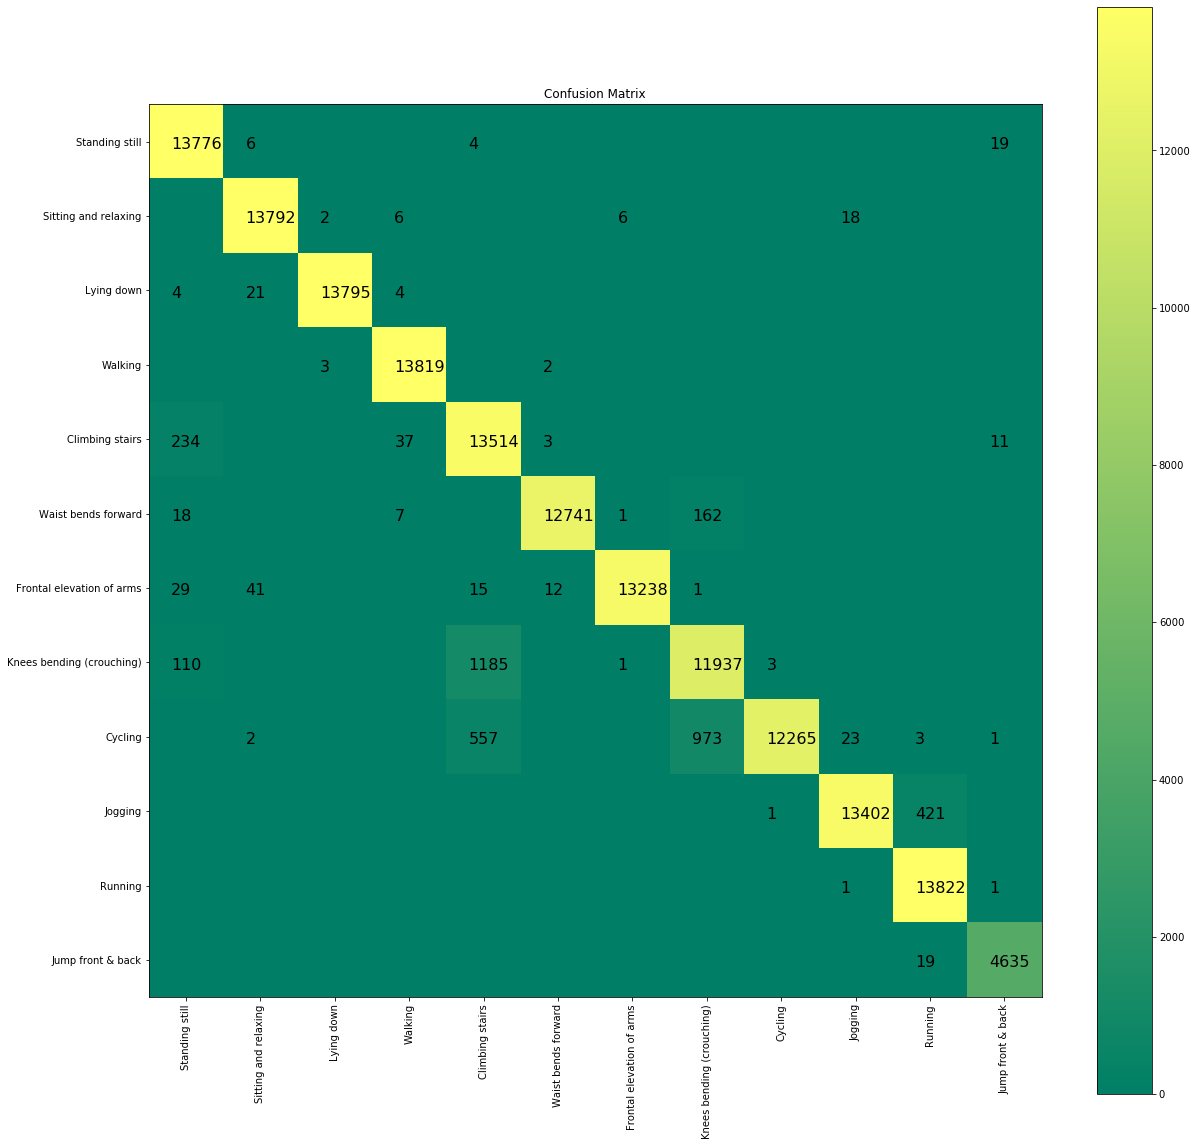

In [17]:
# draw the confusion matrix heatmap

labels =['Standing still','Sitting and relaxing','Lying down',
        'Walking', 'Climbing stairs', 'Waist bends forward',
        'Frontal elevation of arms', 'Knees bending (crouching)',
         'Cycling', 'Jogging', 'Running', 'Jump front & back']

fig = plt.figure(figsize=(20,20))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(12), [l for l in labels], rotation=90)
_ = plt.yticks(range(12), [l for l in labels])

In [19]:
# get the confusion matrix and classification report for test dataset

y_pred_test = model.predict([x_test,x_test,x_test,x_test])
max_y_pred_test = np.argmax(y_pred_test, axis=1)+1
class_report_test = classification_report(y_test, max_y_pred_test)
conf_mat_test = confusion_matrix(y_test, max_y_pred_test)
print(class_report_test)
print(conf_mat_test)

              precision    recall  f1-score   support

         1.0       1.00      0.99      1.00      1537
         2.0       1.00      1.00      1.00      1536
         3.0       1.00      1.00      1.00      1536
         4.0       1.00      0.84      0.92      1536
         5.0       0.85      0.87      0.86      1511
         6.0       0.92      1.00      0.96      1229
         7.0       1.00      0.89      0.94      1382
         8.0       0.84      1.00      0.91      1434
         9.0       1.00      1.00      1.00      1536
        10.0       1.00      1.00      1.00      1536
        11.0       1.00      1.00      1.00      1536
        12.0       1.00      1.00      1.00       486

    accuracy                           0.96     16795
   macro avg       0.97      0.97      0.96     16795
weighted avg       0.97      0.96      0.96     16795

[[1524    0    0    0    0   13    0    0    0    0    0    0]
 [   0 1536    0    0    0    0    0    0    0    0    0    0]
 [   0 

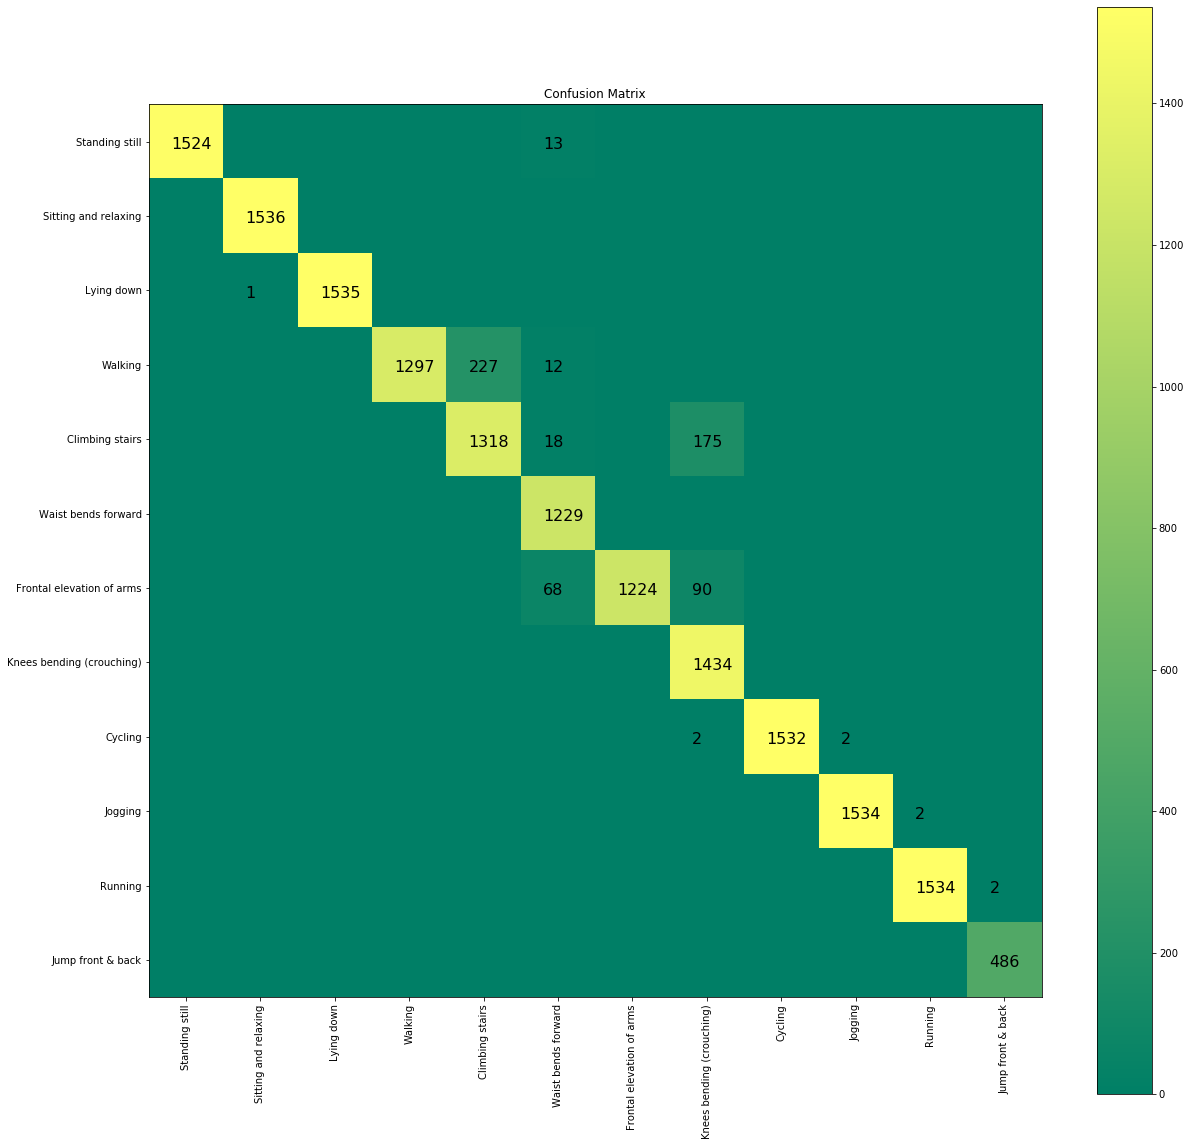

In [21]:
# draw the confusion matrix heatmap for test data
labels =['Standing still','Sitting and relaxing','Lying down',
        'Walking', 'Climbing stairs', 'Waist bends forward',
        'Frontal elevation of arms', 'Knees bending (crouching)',
         'Cycling', 'Jogging', 'Running', 'Jump front & back']

fig = plt.figure(figsize=(20,20))
width = np.shape(conf_mat_test)[1]
height = np.shape(conf_mat_test)[0]

res = plt.imshow(np.array(conf_mat_test), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat_test):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(12), [l for l in labels], rotation=90)
_ = plt.yticks(range(12), [l for l in labels])

In [81]:
# save the best model
# model.save('Multiheaded_CNN_model_version_1.h5')

In [2]:
# reload the saved model
from tensorflow.keras.models import load_model
model_test=load_model('Multiheaded_CNN_model_version_1.h5', compile=False)

/Users/yuanyaning/opt/anaconda3/envs/deeplearning/lib/python3.6/site-packages/tensorflow/python/keras/utils/conv_utils.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


In [3]:
# get the model architecture
model_test.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 100, 21)      0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 100, 21)      0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           (None, 100, 21)      0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 100, 21)      0                                            
__________________________________________________________________________________________________
conv1d_34 